In [1]:
import pandas as pd 
import numpy as np 
import src.fold
from tqdm import tqdm 
import requests
from src.files import *
import io
from src.fold import * 
import re
from Bio.Seq import Seq
import glob 
import seaborn as sns 
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

ece_id = 'ece_26_1334'
genome_ids = ['methanoperedens_1', 'methanoperedens_2', ece_id]

# Convert the GenBank files to other file formats 
for genome_id in genome_ids:
    path = os.path.join('../data/', f'{genome_id}.gbk')
    genbank_file = GenBankFile.from_file(path)
    genbank_file.to_fasta(path.replace('.gbk', '.fa'))
    genbank_file.to_gff(path.replace('.gbk', '.gff'))

# srun foldseek easy-search ./esmfold/ /shared/db/foldseek/latest/db/pdb ./foldseek/ece_26_1334-pdb.tsv tmp/ -s 7.5 --format-mode 4 --format-output query,target,theader,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov,taxid,taxname,taxlineage --threads 64
# srun foldseek easy-search ./esmfold/ /shared/db/foldseek/latest/db/alphafold_uniprot ./foldseek/ece_26_1334-uniprot.tsv tmp/ -s 7.5 --format-mode 4 --format-output query,target,theader,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov,taxid,taxname,taxlineage --threads 64
# featureCounts -p -T 64 -g ID -t CDS -a ece_26_1334.gff -s 2 -o ./metat/n_middle_2025-ece_26_1334_read_counts ./metat/n_middle_2025-ece_26_1334.bam

In [2]:
# ! makeblastdb -in ../data/borg_family_members.faa -dbtype prot -out ../blast/databases/borg_family_members -title "borg_family_members"

# "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovhsp"
# ! blastp -query ../data/ece_26_1334.fa -db ../data/blast/databases/borg_family_members -out ../data/blast/output/ece_26_1334-borg_family_members.tsv -outfmt "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovhsp"

In [ ]:
cols = 'qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovhsp'
blast_df = pd.read_csv('../data/blast/output/ece_26_1334-borg_family_members.tsv', sep='\t', names=cols.split(), header=None)

In [ ]:
# blast_df.sort_values('bitscore', ascending=False).drop_duplicates('qseqid')


In [ ]:
# I am honestly a bit curious about other potential proteins on the element that Prodigal may have missed. 
start_codons = ['ATG', 'GTG', 'TTG']
start_codon_pattern = f'(?=({'|'.join(start_codons)}))' # Use lookahead to support overlapping start codons. 
stop_codons = ['TAG', 'TAA', 'TGA']
ece_seq = FASTAFile.from_file(f'../data/{ece_id}.fn').seqs[0]
ece_seq_reverse = str(Seq(ece_seq).reverse_complement())

# ece_df = FASTAFile.from_file(f'../data/{ece_id}.fa').to_df(parse_description=False)
ece_df = GenBankFile.from_file(f'../data/{ece_id}.gbk').to_df()
ece_df['id'] = [f'{ece_id}_{i + 1}' for i in range(len(ece_df))]
ece_df = ece_df.set_index('id')

ece_stops = ece_df.stop.unique()
ece_starts = ece_df.start.unique() - 1

def get_orfs(seq, strand:str='+'):
    get_codons = lambda start: np.array([seq[i:i + 3] for i in range(start, len(seq), 3)])
    orf_df = list()
    for start_codon_match in re.finditer(start_codon_pattern, seq):
        row = {'strand':strand}
        row['start'] = start_codon_match.start()
        row['start_codon'] = seq[row['start']:row['start'] + 3]
        codons = get_codons(row['start'])

        if np.any(np.isin(codons, stop_codons)):
            stop_codon_idx = np.where(np.isin(codons, stop_codons))[0][0] # Get the first instance of a stop codon.
            nt_seq = ''.join(codons[:stop_codon_idx + 1])
            row['stop'] = row['start'] + len(nt_seq)
            row['nt_seq'] = nt_seq
            row['stop_codon'] = codons[stop_codon_idx]
            row['seq'] = str(Seq(nt_seq).translate()).replace('*', '')
            orf_df.append(row)

    orf_df = pd.DataFrame(orf_df)
    orf_df['length'] = orf_df.seq.apply(len)
    orf_df = orf_df[orf_df.length > 9].copy()
    orf_df = orf_df.sort_values('length', ascending=False).groupby('stop', as_index=False).first() # Want to get the longest sequence for each stop codon. 

    if strand == '-':
        orf_df['stop'] = len(seq) - orf_df.start 
        orf_df['start'] = orf_df.stop - orf_df.nt_seq.apply(len)
    
    return orf_df

ece_all_orfs_df = pd.concat([get_orfs(ece_seq), get_orfs(ece_seq_reverse, strand='-')]).reset_index()
ece_all_orfs_df['already_predicted'] = (ece_all_orfs_df.stop.isin(ece_stops) & (ece_all_orfs_df.strand == '+')) | (ece_all_orfs_df.start.isin(ece_starts) & (ece_all_orfs_df.strand == '-'))
assert (ece_all_orfs_df.already_predicted.sum() == len(ece_df)), 'Some of the ORFs already predicted by Prodigal were not accounted for.'
ece_all_orfs_df = ece_all_orfs_df[~ece_all_orfs_df.already_predicted].copy() # Grab the new ORFs. 

ece_all_orfs_df['gene_id'] = [f'1_{i + 1 + len(ece_df)}' for i in range(len(ece_all_orfs_df))] # Start the gene numbering at 38. 
ece_all_orfs_df = ece_all_orfs_df.set_index('gene_id')
FASTAFile.from_df(ece_all_orfs_df).write(f'../data/{ece_id}_all_orfs.fa')



In [ ]:
fold_esm(f'../data/{ece_id}_all_orfs.fa')
fold_esm(f'../data/{ece_id}.fa')

fold_esm:   9%|▉         | 31/354 [05:25<56:06, 10.42s/it]  

In [ ]:
ece_df = [ece_df.assign(already_predicted=True)]
ece_df += [orf_df[~orf_df.already_predicted & (orf_df.length > 30)].copy()]
ece_df = pd.concat(ece_df)
ece_df['product'] = ece_df['product'].fillna('hypothetical protein')


In [1]:


def to_gff(df:pd.DataFrame, path:str=f'../data/{ece_id}_all_orfs.gff', model='Prodigal', contig_id:str='Final_SR-VP_05_06_2024_coassembly_19kb_linear_ECE_26_1334_complete'):
    with open(path, 'w') as f:
        f.write('##gff-version  3\n')
    
    cols = ['contig_id', 'model', 'feature_type', 'start', 'stop', 'score', 'strand', 'frame', 'description']
    gff_df = df.copy()
    gff_df['model'] = model
    gff_df['feature_type'] = 'CDS'
    gff_df['start'] = gff_df.start + 1
    gff_df['frame'] = 0
    gff_df['score'] = '-'
    if contig_id is not None:
        gff_df['contig_id'] = gff_df.contig_id.fillna()
    # gff_df['description'] = [f'ID={id_};{product}' for id_, product in zip(gff_df.index.values, gff_df['product'].values)]
    gff_df['description'] = [f'ID={gene_id}' for gene_id in df.gene_id]
    gff_df = gff_df[cols].copy()
    gff_df.to_csv(path, header=None, sep='\t', index=False, mode='a') # Append to the file which already has the header. 


# The GFF file is what was used to map the reads, so need to make sure the proteins line up. 


NameError: name 'ece_id' is not defined

<Axes: xlabel='length', ylabel='confidence'>

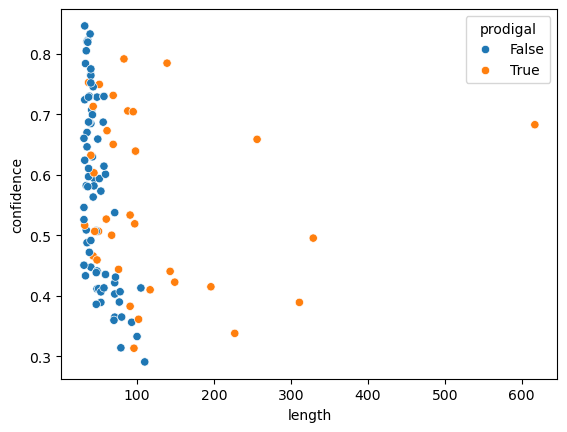

In [ ]:
figure_df = list()
for path in glob.glob('../data/structures/esmfold/*'):
    confidence, _ = fold_esm_get_confidence(path)
    id_ = os.path.basename(path).replace('.pdb', '')
    figure_df.append({'confidence':confidence, 'id':id_, 'prodigal':not ('all_orfs' in path)})
figure_df = pd.DataFrame(figure_df)
figure_df['length'] = figure_df['id'].map(ece_df.seq.apply(len))

# sns.kdeplot(figure_df, x='confidence', hue='prodigal', common_norm=False)
sns.scatterplot(figure_df, x='length', y='confidence', hue='prodigal')